In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.2.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-szgwcwpk
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-szgwcwpk
  Running command git checkout -q 75ebeeaea0908c5527e7b1e305fbc7681382db47
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit 75ebeeaea0908c5527e7b1e305fbc7681382db47
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch3d: filename=pytorch3d-0.7.8-cp312-cp312-linux_x86_64.whl size=61610191 sha256=f819f73a7cc9cf00afca03263c0eddd53f97c9a6c0c182865af5d732be7f42bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-q44nh_bu/wheels/e9/ec/88/13a99edfc9de29485b221df3503c3bca62e23abac9f2b3a974
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=2f48299be9c3974c44ca00b

In [ ]:
%%capture
!pip install torchmetrics
!pip install av
!pip install smplx


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
###

In [ ]:
# ================================
# nerf_single_subject.py
# Basic NeRF for female-1-casual
# ================================
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from pytorch3d.renderer import RayBundle
from pytorch3d.renderer.implicit.utils import ray_bundle_to_ray_points
from scipy.spatial.transform import Rotation as R
import math
import cv2
# -------------------------------
# 1. HarmonicEmbedding
# -------------------------------
class HarmonicEmbedding(nn.Module):
    def __init__(self, n_harmonic_functions=60, omega0=0.1):
        super().__init__()
        self.register_buffer(
            "frequencies",
            omega0 * (2.0 ** torch.arange(n_harmonic_functions)),
        )
    def forward(self, x):
        """
        x: [..., D]
        return: [..., D * n_harmonic * 2]
        """
        embed = (x[..., None] * self.frequencies) # [..., D, n_harm]
        embed = embed.reshape(*x.shape[:-1], -1) # [..., D*n_harm]
        return torch.cat((embed.sin(), embed.cos()), dim=-1)
# -------------------------------
# 2. Basic NeRF
# -------------------------------
class NeuralRadianceField(nn.Module):
    def __init__(self, n_harmonic_functions=60, n_hidden_neurons=256):
        super().__init__()
        self.harmonic_embedding = HarmonicEmbedding(n_harmonic_functions)
        embedding_dim = n_harmonic_functions * 2 * 3 # 3 coordinates
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, n_hidden_neurons),
            nn.Softplus(beta=10.0),
            nn.Linear(n_hidden_neurons, n_hidden_neurons),
            nn.Softplus(beta=10.0),
            nn.Linear(n_hidden_neurons, n_hidden_neurons),
            nn.Softplus(beta=10.0),
            nn.Linear(n_hidden_neurons, n_hidden_neurons),
            nn.Softplus(beta=10.0),
)

        self.color_layer = nn.Sequential(
            nn.Linear(n_hidden_neurons + embedding_dim, n_hidden_neurons),
            nn.Softplus(beta=10.0),
            nn.Linear(n_hidden_neurons, 3),
            nn.Sigmoid(),
        )
        self.density_layer = nn.Sequential(
            nn.Linear(n_hidden_neurons, 1),
            nn.Softplus(beta=10.0),
        )
        # Set initial densities small
        self.density_layer[0].bias.data[0] = -1.5
    def _get_densities(self, features):
        # Return sigma >= 0 (not alpha)
        sigmas = self.density_layer(features)
        return sigmas
    def _get_colors(self, features, rays_directions):
        """
        features: [..., N_samples, C]
        rays_directions: [..., 3] or [..., N_samples, 3]
        """
        spatial_size = features.shape[:-1] # e.g. [N_rays, N_samples]
        rays_directions_normed = F.normalize(rays_directions, dim=-1)
        rays_embedding = self.harmonic_embedding(rays_directions_normed)
        # If directions have fewer dimensions than features
        if len(spatial_size) > len(rays_embedding.shape[:-1]):
            # e.g. dirs: [N_rays,3], features: [N_rays, N_samples, C]
            expand_shape = spatial_size + (rays_embedding.shape[-1],)
            rays_embedding_expand = rays_embedding[..., None, :].expand(*expand_shape)
        else:
            rays_embedding_expand = rays_embedding
        color_input = torch.cat((features, rays_embedding_expand), dim=-1)
        return self.color_layer(color_input)
    def forward(self, ray_bundle: RayBundle, **kwargs):
        # Points along rays: [..., N_samples, 3]
        rays_points_world = ray_bundle_to_ray_points(ray_bundle)
        embeds = self.harmonic_embedding(rays_points_world)
        features = self.mlp(embeds)
        sigmas = self._get_densities(features)
        colors = self._get_colors(features, ray_bundle.directions)
        return sigmas, colors
# -------------------------------
# 3. Volume rendering
# -------------------------------
def volume_render(sigmas, colors, t_vals, white_bg=True):
    """
    sigmas: [N_rays, N_samples, 1]
    colors: [N_rays, N_samples, 3]
    t_vals: [N_rays, N_samples]
    """
    # Distances between samples
    deltas = t_vals[..., 1:] - t_vals[..., :-1] # [N_rays, N_samples-1]
    delta_inf = 1e10 * torch.ones_like(deltas[..., :1])
    deltas = torch.cat([deltas, delta_inf], dim=-1) # [N_rays, N_samples]
    deltas = deltas.unsqueeze(-1) # [N_rays, N_samples, 1]
    # alpha = 1 - exp(-sigma * delta)
    alphas = 1.0 - torch.exp(-sigmas * deltas)
    eps = 1e-10
    # T_i
    trans = torch.cumprod(
        torch.cat([torch.ones_like(alphas[:, :1]), 1.0 - alphas + eps], dim=1),
        dim=1,
    )
    trans = trans[:, :-1]
    weights = alphas * trans # [N_rays, N_samples, 1]
    rgb = (weights * colors).sum(dim=1) # [N_rays, 3]
    acc = weights.sum(dim=1) # [N_rays, 1]
    if white_bg:
        rgb = rgb + (1.0 - acc) * 1.0
    return rgb, acc
# -------------------------------
# 4. Dataset for single subject
# (video + camera.pkl)
# -------------------------------
class PeopleSnapshotDataset(Dataset):
    """
    Expected structure:
      subject_dir/
        female-1-casual.mp4
        camera.pkl
    No masks or poses required.
    """
    def __init__(
        self,
        subject_dir,
        video_name="female-1-casual.mp4",
        n_rays=1024,
        n_samples=64,
        near=0.5,
        far=3.0,
        device="cpu",
    ):
        super().__init__()
        self.subject_dir = subject_dir
        self.n_rays = n_rays
        self.n_samples = n_samples
        self.near = near
        self.far = far
        self.device = device
        # ---------- video ----------
        video_path = os.path.join(subject_dir, video_name)
        print("Loading video from:", video_path)
        video, _, _ = torchvision.io.read_video(video_path, pts_unit="sec")
        self.frames = (video.float() / 255.0) # [F,H,W,3]
        self.num_frames, self.H, self.W, _ = self.frames.shape
        print("Video shape:", self.frames.shape)
        # ---------- camera ----------
        cam_path = os.path.join(subject_dir, "camera.pkl")
        print("Loading camera from:", cam_path)
        with open(cam_path, "rb") as f:
            self.cam = pickle.load(f, encoding="latin1")
        print("camera.pkl keys:", self.cam.keys())
        # ---------- INTRINSICS ----------
        if 'camera_f' in self.cam and 'camera_c' in self.cam:
            camera_f = np.array(self.cam['camera_f'])
            camera_c = np.array(self.cam['camera_c'])
            print("camera_f shape:", camera_f.shape)
            print("camera_c shape:", camera_c.shape)
            if camera_f.ndim == 0 or camera_f.size == 1:
                self.fx = self.fy = float(camera_f)
            elif camera_f.size == 2:
                self.fx = float(camera_f[0])
                self.fy = float(camera_f[1])
            else:
                raise ValueError(f"Unexpected camera_f shape: {camera_f.shape}")
            self.cx = float(camera_c[0])
            self.cy = float(camera_c[1])
        else:
            K_all = np.array(self.cam["camera_k"])
            print("camera_k shape:", K_all.shape)
            if K_all.ndim == 3:
                # [F,3,3] -> take first frame
                K = K_all[0]
                self.fx = float(K[0, 0])
                self.fy = float(K[1, 1])
                self.cx = float(K[0, 2])
                self.cy = float(K[1, 2])
            elif K_all.ndim == 2:
                # [3,3] directly
                K = K_all
                self.fx = float(K[0, 0])
                self.fy = float(K[1, 1])
                self.cx = float(K[0, 2])
                self.cy = float(K[1, 2])
            elif K_all.ndim == 1:
                # 1D vector - common formats:
                # either [fx, fy, cx, cy], or flatten 3x3
                if K_all.size == 4:
                    self.fx = float(K_all[0])
                    self.fy = float(K_all[1])
                    self.cx = float(K_all[2])
                    self.cy = float(K_all[3])
                elif K_all.size == 9:
                    K = K_all.reshape(3, 3)
                    self.fx = float(K[0, 0])
                    self.fy = float(K[1, 1])
                    self.cx = float(K[0, 2])
                    self.cy = float(K[1, 2])
                else:
                    raise ValueError(f"Unexpected camera_k format: {K_all.shape}, size={K_all.size}")
            else:
                raise ValueError(f"Unexpected camera_k format: ndim={K_all.ndim}, shape={K_all.shape}")
        print(f"Intrinsics: fx={self.fx}, fy={self.fy}, cx={self.cx}, cy={self.cy}")
        # extrinsics: camera_rt -> [F,3,4] or [F,4,4]
        rt_all = np.array(self.cam["camera_rt"])
        print("camera_rt shape:", rt_all.shape)
        if rt_all.shape == (3,):
            R_mat = R.from_rotvec(rt_all).as_matrix()
            R_all = np.stack([R_mat] * self.num_frames)
            t_all_np = np.array(self.cam["camera_t"])
            print("camera_t shape:", t_all_np.shape)
            if t_all_np.shape != (3,):
                raise ValueError(f"Unexpected camera_t shape: {t_all_np.shape}")
            t_all = np.stack([t_all_np] * self.num_frames)
        elif rt_all.shape[-2:] == (3, 4):
            R_all = rt_all[..., :3]
            t_all = rt_all[..., 3]
        elif rt_all.shape[-2:] == (4, 4):
            R_all = rt_all[..., :3, :3]
            t_all = rt_all[..., :3, 3]
        else:
            raise ValueError(f"Unexpected camera_rt shape: {rt_all.shape}")
        self.R_all = torch.from_numpy(R_all).float() # [F,3,3]
        self.T_all = torch.from_numpy(t_all).float() # [F,3]
        print("R_all shape:", self.R_all.shape)
        print("T_all shape:", self.T_all.shape)
    def __len__(self):
        return self.num_frames
    def _sample_pixels(self, frame_idx):
        """
        Sample random pixels across the frame.
        (No masks available)
        """
        ys = torch.randint(0, self.H, (self.n_rays,))
        xs = torch.randint(0, self.W, (self.n_rays,))
        return xs, ys
    def __getitem__(self, idx):
        frame_idx = idx
        frame = self.frames[frame_idx] # [H,W,3]
        R = self.R_all[frame_idx] # [3,3]
        T = self.T_all[frame_idx] # [3]
        xs, ys = self._sample_pixels(frame_idx) # [N_rays]
        target_rgb = frame[ys, xs] # [N_rays,3]
        # Coordinates in camera system
        x_cam = (xs.float() - self.cx) / self.fx
        y_cam = (ys.float() - self.cy) / self.fy
        ones = torch.ones_like(x_cam)
        dirs_cam = torch.stack([x_cam, y_cam, ones], dim=-1) # [N_rays,3]
        dirs_cam = F.normalize(dirs_cam, dim=-1)
        R_t = R.t()
        dirs_world = (R_t @ dirs_cam.T).T # [N_rays,3]
        cam_center = -R_t @ T # [3]
        origins = cam_center[None, :].expand_as(dirs_world) # [N_rays,3]
        # t-samples along rays
        t_vals = torch.linspace(self.near, self.far, self.n_samples)
        t_vals = t_vals.view(1, -1).expand(self.n_rays, -1) # [N_rays,N_samples]
        ray_bundle = RayBundle(
            origins=origins.to(self.device),
            directions=dirs_world.to(self.device),
            lengths=t_vals.to(self.device),
            xys=None,
        )
        return ray_bundle, target_rgb.to(self.device)
# -------------------------------
# 5. Training loop
# -------------------------------
def train_nerf(
    subject_dir,
    video_name="female-1-casual.mp4",
    device="cuda",
    n_epochs=5,
    batch_size=1,
    n_rays=1024,
    n_samples=64,
    lr=1e-4,
):
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    dataset = PeopleSnapshotDataset(
        subject_dir=subject_dir,
        video_name=video_name,
        n_rays=n_rays,
        n_samples=n_samples,
        device=device,
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x[0])
    model = NeuralRadianceField().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0.0
        for ray_bundle, target_rgb in dataloader:
            optimizer.zero_grad()
            sigmas, colors = model(ray_bundle)
            t_vals = ray_bundle.lengths
            pred_rgb, _ = volume_render(sigmas, colors, t_vals)
            loss = F.mse_loss(pred_rgb, target_rgb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{n_epochs} | loss = {avg_loss:.6f}")
    return model, dataset
# -------------------------------
# Evaluation
# -------------------------------
def evaluate_nerf(model, dataset, frame_idx, device, batch_size=4096):
    model.eval()
    with torch.no_grad():
        # Get ground truth
        gt_image = dataset.frames[frame_idx].to(device)  # [H, W, 3]
        H, W = dataset.H, dataset.W
        R = dataset.R_all[frame_idx].to(device)
        T = dataset.T_all[frame_idx].to(device)
        fx, fy, cx, cy = dataset.fx, dataset.fy, dataset.cx, dataset.cy
        # Generate all pixel coordinates
        ys, xs = torch.meshgrid(torch.arange(H, device=device), torch.arange(W, device=device), indexing='ij')
        xs = xs.flatten()
        ys = ys.flatten()
        num_rays = H * W
        pred_image = torch.zeros(num_rays, 3, device=device)
        for start in range(0, num_rays, batch_size):
            end = min(start + batch_size, num_rays)
            xs_batch = xs[start:end]
            ys_batch = ys[start:end]
            x_cam = (xs_batch.float() - cx) / fx
            y_cam = (ys_batch.float() - cy) / fy
            ones = torch.ones_like(x_cam)
            dirs_cam = torch.stack([x_cam, y_cam, ones], dim=-1)  # [batch, 3]
            dirs_cam = F.normalize(dirs_cam, dim=-1)
            R_t = R.t()
            dirs_world = (R_t @ dirs_cam.T).T  # [batch, 3]
            cam_center = -R_t @ T  # [3]
            origins = cam_center[None, :].expand_as(dirs_world)  # [batch, 3]
            t_vals = torch.linspace(dataset.near, dataset.far, dataset.n_samples, device=device)
            t_vals = t_vals.view(1, -1).expand(len(xs_batch), -1)  # [batch, N_samples]
            ray_bundle = RayBundle(
                origins=origins,
                directions=dirs_world,
                lengths=t_vals,
                xys=None,
            )
            sigmas, colors = model(ray_bundle)
            pred_rgb, _ = volume_render(sigmas, colors, t_vals)
            pred_image[start:end] = pred_rgb
        pred_image = pred_image.reshape(H, W, 3)
        # Compute metrics
        mse = F.mse_loss(pred_image, gt_image)
        psnr = -10.0 * math.log10(mse.item())
        # Save images (optional)
        torchvision.utils.save_image(pred_image.permute(2,0,1), f"rendered_frame_{frame_idx}.png")
        torchvision.utils.save_image(gt_image.permute(2,0,1), f"gt_frame_{frame_idx}.png")
        return psnr
# -------------------------------
# 6. Entry point
# -------------------------------
if __name__ == "__main__":
    # Specified path
    subject_dir = "/content/drive/MyDrive/people_snapshot_public/female-1-casual"
    video_name = "female-1-casual.mp4"
    model, dataset = train_nerf(
        subject_dir=subject_dir,
        video_name=video_name,
        device="cuda",
        n_epochs=150,
        batch_size=1,
        n_rays=2048,
        n_samples=128,
        lr=1e-4,
    )
    # Evaluate on a sample frame, e.g., frame 0
    psnr = evaluate_nerf(model, dataset, frame_idx=0, device="cuda")
    print(f"PSNR for frame 0: {psnr:.2f} dB")

Using device: cuda
Loading video from: /content/drive/MyDrive/people_snapshot_public/female-1-casual/female-1-casual.mp4
Video shape: torch.Size([757, 1080, 1080, 3])
Loading camera from: /content/drive/MyDrive/people_snapshot_public/female-1-casual/camera.pkl
camera.pkl keys: dict_keys(['camera_k', 'camera_rt', 'camera_c', 'camera_f', 'height', 'width', 'camera_t'])
camera_f shape: (2,)
camera_c shape: (2,)
Intrinsics: fx=2664.229745219409, fy=2664.692774216014, cx=511.7805539129703, cy=567.1254292628388
camera_rt shape: (3,)
camera_t shape: (3,)
R_all shape: torch.Size([757, 3, 3])
T_all shape: torch.Size([757, 3])
Epoch 1/150 | loss = 0.003330
Epoch 2/150 | loss = 0.001979
Epoch 3/150 | loss = 0.001811
Epoch 4/150 | loss = 0.001756
Epoch 5/150 | loss = 0.001711
Epoch 6/150 | loss = 0.001705
Epoch 7/150 | loss = 0.001695
Epoch 8/150 | loss = 0.001672
Epoch 9/150 | loss = 0.001666
Epoch 10/150 | loss = 0.001657
Epoch 11/150 | loss = 0.001656
Epoch 12/150 | loss = 0.001641
Epoch 13/150

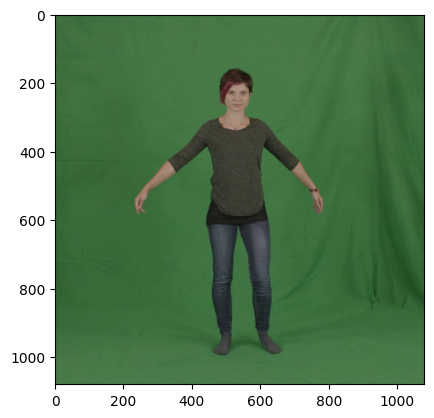

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img


im = img.imread('/content/gt_frame_0.png')
plt.imshow(im)

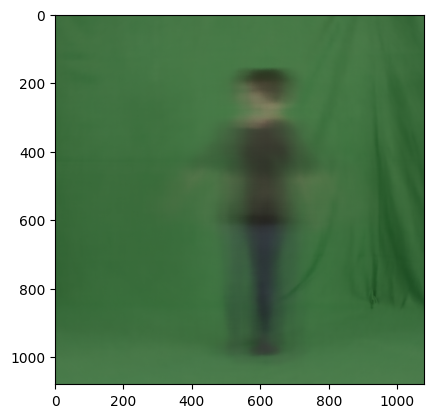

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img


im = img.imread('/content/rendered_frame_0.png')
plt.imshow(im)

In [ ]:
def render_new_view(model, dataset, new_R, new_T, H, W, device, batch_size=4096, output_path="new_view.png"):
    model.eval()
    with torch.no_grad():
        fx, fy, cx, cy = dataset.fx, dataset.fy, dataset.cx, dataset.cy
        ys, xs = torch.meshgrid(torch.arange(H, device=device), torch.arange(W, device=device), indexing='ij')
        xs = xs.flatten()
        ys = ys.flatten()
        num_rays = H * W
        pred_image = torch.zeros(num_rays, 3, device=device)

        for start in range(0, num_rays, batch_size):
            end = min(start + batch_size, num_rays)
            xs_batch = xs[start:end]
            ys_batch = ys[start:end]
            x_cam = (xs_batch.float() - cx) / fx
            y_cam = (ys_batch.float() - cy) / fy
            ones = torch.ones_like(x_cam)
            dirs_cam = torch.stack([x_cam, y_cam, ones], dim=-1)
            dirs_cam = F.normalize(dirs_cam, dim=-1)
            R_t = new_R.t()  # New rotation matrix
            dirs_world = (R_t @ dirs_cam.T).T
            cam_center = -R_t @ new_T  # New translation
            origins = cam_center[None, :].expand_as(dirs_world)
            t_vals = torch.linspace(dataset.near, dataset.far, dataset.n_samples, device=device).view(1, -1).expand(len(xs_batch), -1)
            ray_bundle = RayBundle(origins=origins, directions=dirs_world, lengths=t_vals, xys=None)
            sigmas, colors = model(ray_bundle)
            pred_rgb, _ = volume_render(sigmas, colors, t_vals)
            pred_image[start:end] = pred_rgb

        pred_image = pred_image.reshape(H, W, 3)
        torchvision.utils.save_image(pred_image.permute(2, 0, 1), output_path)
        print(f"Image saved to {output_path}")
        return pred_image.cpu()

In [ ]:
dataset = PeopleSnapshotDataset(
    subject_dir="/content/drive/MyDrive/people_snapshot_public/female-1-casual",  # Путь к директории с видео и camera.pkl
    video_name="female-1-casual.mp4",
    n_rays=1024,
    n_samples=64,
    near=0.5,
    far=3.0,
    device="cuda"
)

Loading video from: /content/drive/MyDrive/people_snapshot_public/female-1-casual/female-1-casual.mp4
Video shape: torch.Size([757, 1080, 1080, 3])
Loading camera from: /content/drive/MyDrive/people_snapshot_public/female-1-casual/camera.pkl
camera.pkl keys: dict_keys(['camera_k', 'camera_rt', 'camera_c', 'camera_f', 'height', 'width', 'camera_t'])
camera_f shape: (2,)
camera_c shape: (2,)
Intrinsics: fx=2664.229745219409, fy=2664.692774216014, cx=511.7805539129703, cy=567.1254292628388
camera_rt shape: (3,)
camera_t shape: (3,)
R_all shape: torch.Size([757, 3, 3])
T_all shape: torch.Size([757, 3])


In [ ]:

import torch
from scipy.spatial.transform import Rotation as R_scipy  # To create rotation matrices easily

# Define device (add this if not already defined)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a new rotation (e.g., rotate camera by 30 degrees around Y-axis)
rot = R_scipy.from_euler('y', 30, degrees=True).as_matrix()  # 30 deg rotation around Y
new_R = torch.from_numpy(rot).float().to(device)  # [3,3]

# Define a new translation (e.g., move camera back along Z by 1 unit)
new_T = torch.tensor([0.0, 0.0, 1.0], device=device)  # [3]

# Render the new view with the same H and W as dataset
rendered_image = render_new_view(
    model=model,
    dataset=dataset,
    new_R=new_R,
    new_T=new_T,
    H=dataset.H,
    W=dataset.W,
    device=device,
    batch_size=4096,  # Adjust based on GPU memory
    output_path="new_pose_view.png"  # Saves the image
)

print("New view rendered and saved to new_pose_view.png")

Image saved to new_pose_view.png
New view rendered and saved to new_pose_view.png


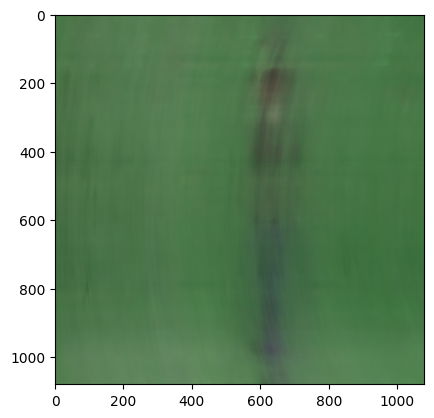

In [ ]:
im = img.imread('/content/new_pose_view.png')
plt.imshow(im)

In [ ]:
!git clone https://github.com/vchoutas/smplx

Cloning into 'smplx'...
remote: Enumerating objects: 728, done.
remote: Counting objects: 100% (275/275), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 728 (delta 236), reused 191 (delta 191), pack-reused 453 (from 1)
Receiving objects: 100% (728/728), 2.39 MiB | 33.08 MiB/s, done.
Resolving deltas: 100% (462/462), done.


In [ ]:
!python /content/smplx/setup.py install

running install
/usr/local/lib/python3.12/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.12/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https

In [ ]:
from smplx.body_models import SMPLX
smplx = SMPLX(
    model_path='/content/smplx/smplx_models/SMPLX_NEUTRAL.npz',
    gender='neutral',
    use_pca=False
)

In [ ]:
smplx

SMPLX(
  Gender: NEUTRAL
  Number of joints: 55
  Betas: 10
  Flat hand mean: False
  Number of Expression Coefficients: 10
  (vertex_joint_selector): VertexJointSelector()
)

In [ ]:
# ================================
# nerf_single_subject.py
# Basic NeRF for female-1-casual
# ================================
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from pytorch3d.renderer import RayBundle
from pytorch3d.renderer.implicit.utils import ray_bundle_to_ray_points
from scipy.spatial.transform import Rotation as R
import math

# -------------------------------
# 1. HarmonicEmbedding
# -------------------------------
class HarmonicEmbedding(nn.Module):
    def __init__(self, n_harmonic_functions=60, omega0=0.1):
        super().__init__()
        self.register_buffer(
            "frequencies",
            omega0 * (2.0 ** torch.arange(n_harmonic_functions)),
        )
    def forward(self, x):
        """
        x: [..., D]
        return: [..., D * n_harmonic * 2]
        """
        embed = (x[..., None] * self.frequencies) # [..., D, n_harm]
        embed = embed.reshape(*x.shape[:-1], -1) # [..., D*n_harm]
        return torch.cat((embed.sin(), embed.cos()), dim=-1)

# -------------------------------
# 2. Basic NeRF
# -------------------------------
class NeuralRadianceField(nn.Module):
    def __init__(self, n_harmonic_functions=60, n_hidden_neurons=256):
        super().__init__()
        self.harmonic_embedding = HarmonicEmbedding(n_harmonic_functions)
        embedding_dim = n_harmonic_functions * 2 * 3 # 3 coordinates
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, n_hidden_neurons),
            nn.Softplus(beta=10.0),
            nn.Linear(n_hidden_neurons, n_hidden_neurons),
            nn.Softplus(beta=10.0),
        )
        self.color_layer = nn.Sequential(
            nn.Linear(n_hidden_neurons + embedding_dim, n_hidden_neurons),
            nn.Softplus(beta=10.0),
            nn.Linear(n_hidden_neurons, 3),
            nn.Sigmoid(),
        )
        self.density_layer = nn.Sequential(
            nn.Linear(n_hidden_neurons, 1),
            nn.Softplus(beta=10.0),
        )
        self.density_layer[0].bias.data[0] = -1.5

    def _get_densities(self, features):
        sigmas = self.density_layer(features)
        return sigmas

    def _get_colors(self, features, rays_directions):
        spatial_size = features.shape[:-1]  # [N_rays, N_samples]
        rays_directions_normed = F.normalize(rays_directions, dim=-1)
        rays_embedding = self.harmonic_embedding(rays_directions_normed)  # [N_rays, embed_dim]

        # Correct expansion: add the samples dimension
        expand_shape = spatial_size + (rays_embedding.shape[-1],)  # [N_rays, N_samples, embed_dim]
        rays_embedding_expand = rays_embedding[..., None, :].expand(*expand_shape)

        color_input = torch.cat((features, rays_embedding_expand), dim=-1)
        return self.color_layer(color_input)

    def forward(self, ray_bundle: RayBundle, **kwargs):
        rays_points_world = ray_bundle_to_ray_points(ray_bundle)
        embeds = self.harmonic_embedding(rays_points_world)
        features = self.mlp(embeds)
        sigmas = self._get_densities(features)
        colors = self._get_colors(features, ray_bundle.directions)
        return sigmas, colors

# -------------------------------
# 3. Volume rendering
# -------------------------------
def volume_render(sigmas, colors, t_vals, white_bg=True):
    """
    sigmas: [N_rays, N_samples, 1]
    colors: [N_rays, N_samples, 3]
    t_vals: [N_rays, N_samples]
    """
    # deltas
    deltas = t_vals[..., 1:] - t_vals[..., :-1]  # [N_rays, N_samples-1]
    deltas = torch.cat([deltas, torch.full_like(deltas[..., :1], 1e10)], dim=-1)  # [N_rays, N_samples]
    deltas = deltas[..., None]  # [N_rays, N_samples, 1]

    # alphas
    alphas = 1 - torch.exp(-sigmas * deltas)  # [N_rays, N_samples, 1]

    # transmittance
    ones = torch.ones_like(alphas[..., :1, :])  # [N_rays, 1, 1]
    padded = torch.cat([ones, 1 - alphas + 1e-10], dim=-2)  # [N_rays, N_samples+1, 1]
    trans = torch.cumprod(padded, dim=-2)[..., :-1, :]  # [N_rays, N_samples, 1]

    # weights
    weights = alphas * trans  # [N_rays, N_samples, 1]

    # rgb
    rgb = torch.sum(weights * colors, dim=-2)  # [N_rays, 3]

    # white background
    if white_bg:
        rgb = rgb + (1 - weights.sum(dim=-2))

    return rgb, weights
# -------------------------------
# 4. Dataset for single subject
# (video + camera.pkl)
# -------------------------------
class PeopleSnapshotDataset(Dataset):
    """
    Expected structure:
      subject_dir/
        female-1-casual.mp4
        camera.pkl
    No masks or poses required.
    """
    def __init__(
        self,
        subject_dir,
        video_name="female-1-casual.mp4",
        n_rays=1024,
        n_samples=64,
        near=0.5,
        far=3.0,
        device="cpu",
    ):
        super().__init__()
        self.subject_dir = subject_dir
        self.n_rays = n_rays
        self.n_samples = n_samples
        self.near = near
        self.far = far
        self.device = device
        # ---------- video ----------
        video_path = os.path.join(subject_dir, video_name)
        print("Loading video from:", video_path)
        video, _, _ = torchvision.io.read_video(video_path, pts_unit="sec")
        self.frames = (video.float() / 255.0) # [F,H,W,3]
        self.num_frames, self.H, self.W, _ = self.frames.shape
        print("Video shape:", self.frames.shape)
        # ---------- camera ----------
        cam_path = os.path.join(subject_dir, "camera.pkl")
        print("Loading camera from:", cam_path)
        with open(cam_path, "rb") as f:
            self.cam = pickle.load(f, encoding="latin1")
        print("camera.pkl keys:", self.cam.keys())
        # ---------- INTRINSICS ----------
        if 'camera_f' in self.cam and 'camera_c' in self.cam:
            camera_f = np.array(self.cam['camera_f'])
            camera_c = np.array(self.cam['camera_c'])
            print("camera_f shape:", camera_f.shape)
            print("camera_c shape:", camera_c.shape)
            if camera_f.ndim == 0 or camera_f.size == 1:
                self.fx = self.fy = float(camera_f)
            elif camera_f.size == 2:
                self.fx = float(camera_f[0])
                self.fy = float(camera_f[1])
            else:
                raise ValueError(f"Unexpected camera_f shape: {camera_f.shape}")
            self.cx = float(camera_c[0])
            self.cy = float(camera_c[1])
        else:
            K_all = np.array(self.cam["camera_k"])
            print("camera_k shape:", K_all.shape)
            if K_all.ndim == 3:
                # [F,3,3] -> take first frame
                K = K_all[0]
                self.fx = float(K[0, 0])
                self.fy = float(K[1, 1])
                self.cx = float(K[0, 2])
                self.cy = float(K[1, 2])
            elif K_all.ndim == 2:
                # [3,3] directly
                K = K_all
                self.fx = float(K[0, 0])
                self.fy = float(K[1, 1])
                self.cx = float(K[0, 2])
                self.cy = float(K[1, 2])
            elif K_all.ndim == 1:
                # 1D vector - common formats:
                # either [fx, fy, cx, cy], or flatten 3x3
                if K_all.size == 4:
                    self.fx = float(K_all[0])
                    self.fy = float(K_all[1])
                    self.cx = float(K_all[2])
                    self.cy = float(K_all[3])
                elif K_all.size == 9:
                    K = K_all.reshape(3, 3)
                    self.fx = float(K[0, 0])
                    self.fy = float(K[1, 1])
                    self.cx = float(K[0, 2])
                    self.cy = float(K[1, 2])
                else:
                    raise ValueError(f"Unexpected camera_k format: {K_all.shape}, size={K_all.size}")
            else:
                raise ValueError(f"Unexpected camera_k format: ndim={K_all.ndim}, shape={K_all.shape}")
        print(f"Intrinsics: fx={self.fx}, fy={self.fy}, cx={self.cx}, cy={self.cy}")
        # extrinsics: camera_rt -> [F,3,4] or [F,4,4]
        rt_all = np.array(self.cam["camera_rt"])
        print("camera_rt shape:", rt_all.shape)
        if rt_all.shape == (3,):
            R_mat = R.from_rotvec(rt_all).as_matrix()
            R_all = np.stack([R_mat] * self.num_frames)
            t_all_np = np.array(self.cam["camera_t"])
            print("camera_t shape:", t_all_np.shape)
            if t_all_np.shape != (3,):
                raise ValueError(f"Unexpected camera_t shape: {t_all_np.shape}")
            t_all = np.stack([t_all_np] * self.num_frames)
        elif rt_all.shape[-2:] == (3, 4):
            R_all = rt_all[..., :3]
            t_all = rt_all[..., 3]
        elif rt_all.shape[-2:] == (4, 4):
            R_all = rt_all[..., :3, :3]
            t_all = rt_all[..., :3, 3]
        else:
            raise ValueError(f"Unexpected camera_rt shape: {rt_all.shape}")
        self.R_all = torch.from_numpy(R_all).float() # [F,3,3]
        self.T_all = torch.from_numpy(t_all).float() # [F,3]
        print("R_all shape:", self.R_all.shape)
        print("T_all shape:", self.T_all.shape)

    def __len__(self):
        return self.num_frames

    def _sample_pixels(self, frame_idx):
        """
        Sample random pixels across the frame.
        (No masks available)
        """
        ys = torch.randint(0, self.H, (self.n_rays,))
        xs = torch.randint(0, self.W, (self.n_rays,))
        return xs, ys

    def __getitem__(self, idx):
        frame_idx = idx
        frame = self.frames[frame_idx] # [H,W,3]
        R = self.R_all[frame_idx] # [3,3]
        T = self.T_all[frame_idx] # [3]
        xs, ys = self._sample_pixels(frame_idx) # [N_rays]
        target_rgb = frame[ys, xs] # [N_rays,3]
        # Coordinates in camera system
        x_cam = (xs.float() - self.cx) / self.fx
        y_cam = (ys.float() - self.cy) / self.fy
        ones = torch.ones_like(x_cam)
        dirs_cam = torch.stack([x_cam, y_cam, ones], dim=-1) # [N_rays,3]
        dirs_cam = F.normalize(dirs_cam, dim=-1)
        R_t = R.t()
        dirs_world = (R_t @ dirs_cam.T).T # [N_rays,3]
        cam_center = -R_t @ T # [3]
        origins = cam_center[None, :].expand_as(dirs_world) # [N_rays,3]
        # t-samples along rays
        t_vals = torch.linspace(self.near, self.far, self.n_samples)
        t_vals = t_vals.view(1, -1).expand(self.n_rays, -1) # [N_rays,N_samples]
        ray_bundle = RayBundle(
            origins=origins.to(self.device),
            directions=dirs_world.to(self.device),
            lengths=t_vals.to(self.device),
            xys=None,
        )
        return ray_bundle, target_rgb.to(self.device)

# -------------------------------
# 5. Training loop
# -------------------------------
def train_nerf(
    subject_dir,
    video_name="female-1-casual.mp4",
    device="cuda",
    n_epochs=5,
    batch_size=1,
    n_rays=1024,
    n_samples=64,
    lr=1e-4,
):
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    dataset = PeopleSnapshotDataset(
        subject_dir=subject_dir,
        video_name=video_name,
        n_rays=n_rays,
        n_samples=n_samples,
        device=device,
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x[0])
    model = NeuralRadianceField().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0.0
        for ray_bundle, target_rgb in dataloader:
            optimizer.zero_grad()
            sigmas, colors = model(ray_bundle)
            t_vals = ray_bundle.lengths
            pred_rgb, _ = volume_render(sigmas, colors, t_vals)
            loss = F.mse_loss(pred_rgb, target_rgb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{n_epochs} | loss = {avg_loss:.6f}")
    return model, dataset

# -------------------------------
# Evaluation
# -------------------------------
def evaluate_nerf(model, dataset, frame_idx, device, batch_size=4096):
    model.eval()
    with torch.no_grad():
        gt_image = dataset.frames[frame_idx].to(device)  # [H, W, 3]
        H, W = dataset.H, dataset.W
        R = dataset.R_all[frame_idx].to(device)
        T = dataset.T_all[frame_idx].to(device)
        fx, fy, cx, cy = dataset.fx, dataset.fy, dataset.cx, dataset.cy
        ys, xs = torch.meshgrid(torch.arange(H, device=device), torch.arange(W, device=device), indexing='ij')
        xs = xs.flatten()
        ys = ys.flatten()
        num_rays = H * W
        pred_image = torch.zeros(num_rays, 3, device=device)
        for start in range(0, num_rays, batch_size):
            end = min(start + batch_size, num_rays)
            xs_batch = xs[start:end]
            ys_batch = ys[start:end]
            x_cam = (xs_batch.float() - cx) / fx
            y_cam = (ys_batch.float() - cy) / fy
            ones = torch.ones_like(x_cam)
            dirs_cam = torch.stack([x_cam, y_cam, ones], dim=-1)  # [batch, 3]
            dirs_cam = F.normalize(dirs_cam, dim=-1)
            R_t = R.t()
            dirs_world = (R_t @ dirs_cam.T).T  # [batch, 3]
            cam_center = -R_t @ T  # [3]
            origins = cam_center[None, :].expand_as(dirs_world)  # [batch, 3]
            t_vals = torch.linspace(dataset.near, dataset.far, dataset.n_samples, device=device)
            t_vals = t_vals.view(1, -1).expand(len(xs_batch), -1)  # [batch, N_samples]
            ray_bundle = RayBundle(
                origins=origins,
                directions=dirs_world,
                lengths=t_vals,
                xys=None,
            )
            sigmas, colors = model(ray_bundle)
            pred_rgb, _ = volume_render(sigmas, colors, t_vals)
            pred_image[start:end] = pred_rgb
        pred_image = pred_image.reshape(H, W, 3)
        mse = F.mse_loss(pred_image, gt_image)
        psnr = -10.0 * math.log10(mse.item())
        torchvision.utils.save_image(pred_image.permute(2,0,1), f"rendered_frame_{frame_idx}.png")
        torchvision.utils.save_image(gt_image.permute(2,0,1), f"gt_frame_{frame_idx}.png")
        return psnr

# -------------------------------
# 6. Entry point
# -------------------------------
if __name__ == "__main__":
    # Specified path
    subject_dir = "/content/drive/MyDrive/people_snapshot_public/female-1-casual"
    video_name = "female-1-casual.mp4"
    model, dataset = train_nerf(
        subject_dir=subject_dir,
        video_name=video_name,
        device="cuda",
        n_epochs=150,
        batch_size=1,
        n_rays=1024,
        n_samples=128,
        lr=1e-4,
    )
    # Evaluate on a sample frame, e.g., frame 0
    psnr = evaluate_nerf(model, dataset, frame_idx=0, device="cuda")
    print(f"PSNR for frame 0: {psnr:.2f} dB")

Using device: cuda
Loading video from: /content/drive/MyDrive/people_snapshot_public/female-1-casual/female-1-casual.mp4


/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(


Video shape: torch.Size([757, 1080, 1080, 3])
Loading camera from: /content/drive/MyDrive/people_snapshot_public/female-1-casual/camera.pkl
camera.pkl keys: dict_keys(['camera_k', 'camera_rt', 'camera_c', 'camera_f', 'height', 'width', 'camera_t'])
camera_f shape: (2,)
camera_c shape: (2,)
Intrinsics: fx=2664.229745219409, fy=2664.692774216014, cx=511.7805539129703, cy=567.1254292628388
camera_rt shape: (3,)
camera_t shape: (3,)
R_all shape: torch.Size([757, 3, 3])
T_all shape: torch.Size([757, 3])
Epoch 1/150 | loss = 0.003708
Epoch 2/150 | loss = 0.002049
Epoch 3/150 | loss = 0.001867
Epoch 4/150 | loss = 0.001784
Epoch 5/150 | loss = 0.001743
Epoch 6/150 | loss = 0.001717
Epoch 7/150 | loss = 0.001697
Epoch 8/150 | loss = 0.001699
Epoch 9/150 | loss = 0.001692
Epoch 10/150 | loss = 0.001676
Epoch 11/150 | loss = 0.001680
Epoch 12/150 | loss = 0.001663
Epoch 13/150 | loss = 0.001654
Epoch 14/150 | loss = 0.001638
Epoch 15/150 | loss = 0.001639
Epoch 16/150 | loss = 0.001627
Epoch 17/

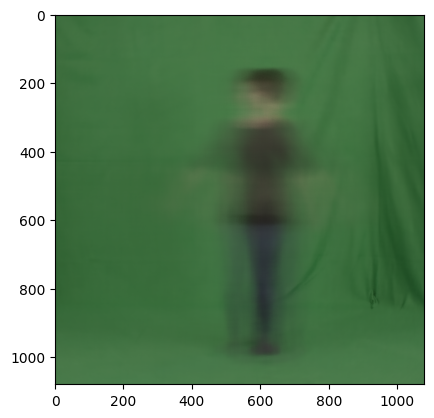

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
im = img.imread('/content/rendered_frame_0.png')
plt.imshow(im)

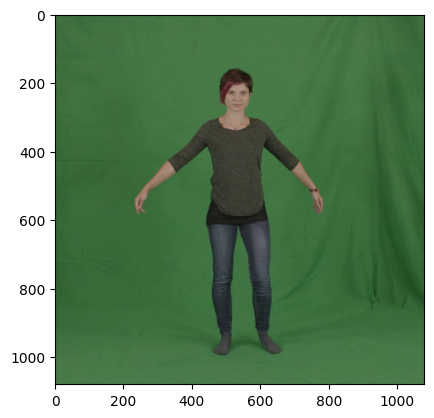

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
im = img.imread('/content/gt_frame_0.png')
plt.imshow(im)

In [ ]:
# ================================
# nerf_avatar.py
# Pose-conditioned NeRF for people_snapshot_public
# ================================

import os
import math
import pickle
import numpy as np
import h5py

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from scipy.spatial.transform import Rotation as R

from pytorch3d.renderer import RayBundle
from pytorch3d.renderer.implicit.utils import ray_bundle_to_ray_points


# -------------------------------
# 1. HarmonicEmbedding
# -------------------------------

class HarmonicEmbedding(nn.Module):
    def __init__(self, n_harmonic_functions=60, omega0=0.1):
        super().__init__()
        self.register_buffer(
            "frequencies",
            omega0 * (2.0 ** torch.arange(n_harmonic_functions)),
        )

    def forward(self, x):
        """
        x: [..., D]
        -> [..., D * n_harmonic_functions * 2]
        """
        embed = (x[..., None] * self.frequencies)  # [..., D, n_harm]
        embed = embed.reshape(*x.shape[:-1], -1)   # [..., D*n_harm]
        return torch.cat((embed.sin(), embed.cos()), dim=-1)


# -------------------------------
# 2. Pose-conditioned NeRF
#    f(x, d, theta, betas) -> (sigma, color)
# -------------------------------

class PoseConditionedNeRF(nn.Module):
    def __init__(
        self,
        n_harmonic_functions_xyz: int = 60,
        n_harmonic_functions_dir: int = 24,
        n_hidden_neurons: int = 256,
        pose_dim: int = 63,
        betas_dim: int = 10,
        pose_embedding_dim: int = 64,
    ):
        super().__init__()

        # для xyz и для направлений можно разные число гармоник
        self.xyz_embedding = HarmonicEmbedding(n_harmonic_functions_xyz)
        self.dir_embedding = HarmonicEmbedding(n_harmonic_functions_dir)

        xyz_embed_dim = n_harmonic_functions_xyz * 2 * 3
        self.pose_dim = pose_dim
        self.betas_dim = betas_dim

        self.pose_embedding = nn.Linear(pose_dim + betas_dim, pose_embedding_dim)

        # MLP  + pose_embed
        self.mlp = nn.Sequential(
            nn.Linear(xyz_embed_dim + pose_embedding_dim, n_hidden_neurons),
            nn.Softplus(beta=10.0),
            nn.Linear(n_hidden_neurons, n_hidden_neurons),
            nn.Softplus(beta=10.0),
        )

        # features + embedding
        dir_embed_dim = n_harmonic_functions_dir * 2 * 3
        self.color_layer = nn.Sequential(
            nn.Linear(n_hidden_neurons + dir_embed_dim, n_hidden_neurons),
            nn.Softplus(beta=10.0),
            nn.Linear(n_hidden_neurons, 3),
            nn.Sigmoid(),
        )

        self.density_layer = nn.Sequential(
            nn.Linear(n_hidden_neurons, 1),
            nn.Softplus(beta=10.0),
        )
        self.density_layer[0].bias.data[0] = -1.5

    def _get_densities(self, features):
        return self.density_layer(features)

    def _get_colors(self, features, rays_directions):
        """
        features: [N_rays, N_samples, C]
        rays_directions: [N_rays, 3]
        """
        spatial_size = features.shape[:-1]  # [N_rays, N_samples]
        rays_directions_normed = F.normalize(rays_directions, dim=-1)

        dir_embed = self.dir_embedding(rays_directions_normed)  # [N_rays, Ddir]


        dir_embed_expand = dir_embed[:, None, :].expand(
            spatial_size[0], spatial_size[1], dir_embed.shape[-1]
        )  # [N_rays, N_samples, Ddir]

        color_input = torch.cat((features, dir_embed_expand), dim=-1)
        return self.color_layer(color_input)

    def forward(self, ray_bundle: RayBundle, body_pose=None, betas=None):
        device = ray_bundle.origins.device

        # body_pose: [pose_dim], betas: [betas_dim]
        if body_pose is None:
            body_pose = torch.zeros(self.pose_dim, device=device)
        if betas is None:
            betas = torch.zeros(self.betas_dim, device=device)

        pose_vec = torch.cat([body_pose, betas], dim=-1)  # [pose_dim + betas_dim]
        pose_emb = self.pose_embedding(pose_vec)          # [pose_emb_dim]


        n_rays = ray_bundle.origins.shape[0]
        n_samples = ray_bundle.lengths.shape[1]
        pose_emb_expand = pose_emb.view(1, 1, -1).expand(n_rays, n_samples, -1)


        rays_points_world = ray_bundle_to_ray_points(ray_bundle)         # [N_rays,N_samples,3]
        xyz_emb = self.xyz_embedding(rays_points_world)                  # [N_rays,N_samples,Exyz]

        mlp_input = torch.cat([xyz_emb, pose_emb_expand], dim=-1)
        features = self.mlp(mlp_input)                                   # [N_rays,N_samples,C]

        sigmas = self._get_densities(features)                           # [N_rays,N_samples,1]
        colors = self._get_colors(features, ray_bundle.directions)       # [N_rays,N_samples,3]

        return sigmas, colors


# -------------------------------
# 3. Volume rendering
# -------------------------------

def volume_render(sigmas, colors, t_vals, white_bg=True):
    """
    sigmas: [N_rays, N_samples, 1]
    colors: [N_rays, N_samples, 3]
    t_vals: [N_rays, N_samples]
    """

    deltas = t_vals[..., 1:] - t_vals[..., :-1]              # [N_rays,N_samples-1]
    delta_inf = 1e10 * torch.ones_like(deltas[..., :1])
    deltas = torch.cat([deltas, delta_inf], dim=-1)          # [N_rays,N_samples]
    deltas = deltas.unsqueeze(-1)                            # [N_rays,N_samples,1]

    # alpha = 1 - exp(-sigma * delta)
    alphas = 1.0 - torch.exp(-sigmas * deltas)               # [N_rays,N_samples,1]

    eps = 1e-10
    # T_i
    trans = torch.cumprod(
        torch.cat([torch.ones_like(alphas[:, :1]), 1.0 - alphas + eps], dim=1),
        dim=1,
    )
    trans = trans[:, :-1]                                    # [N_rays,N_samples,1]

    weights = alphas * trans                                 # [N_rays,N_samples,1]

    rgb = (weights * colors).sum(dim=1)                      # [N_rays,3]
    acc = weights.sum(dim=1)                                 # [N_rays,1]

    if white_bg:
        rgb = rgb + (1.0 - acc) * 1.0

    return rgb, acc


# -------------------------------
# 4. Dataset: video + camera + poses
# -------------------------------

class PeopleSnapshotDataset(Dataset):
    """
    Expected directory structure:
      subject_dir/
        <video_name>.mp4
        camera.pkl
        reconstructed_poses.hdf5  (optional)

    If the HDF5 file is missing or has unexpected keys, the code will not fail;
    instead, it will fall back to zero pose and betas.
    """

    def __init__(
        self,
        subject_dir,
        video_name="female-1-casual.mp4",
        n_rays=1024,
        n_samples=64,
        near=0.5,
        far=3.0,
        device="cpu",
    ):
        super().__init__()
        self.subject_dir = subject_dir
        self.n_rays = n_rays
        self.n_samples = n_samples
        self.near = near
        self.far = far
        self.device = device

        # ---------- видео ----------
        video_path = os.path.join(subject_dir, video_name)
        print("Loading video from:", video_path)
        video, _, _ = torchvision.io.read_video(video_path, pts_unit="sec")
        self.frames = (video.float() / 255.0)                  # [F,H,W,3]
        self.num_frames, self.H, self.W, _ = self.frames.shape
        print("Video shape:", self.frames.shape)

        # ---------- камера ----------
        cam_path = os.path.join(subject_dir, "camera.pkl")
        print("Loading camera from:", cam_path)
        with open(cam_path, "rb") as f:
            self.cam = pickle.load(f, encoding="latin1")
        print("camera.pkl keys:", self.cam.keys())

        # --- intrinsics ---
        if "camera_f" in self.cam and "camera_c" in self.cam:
            camera_f = np.array(self.cam["camera_f"])
            camera_c = np.array(self.cam["camera_c"])
            print("camera_f shape:", camera_f.shape)
            print("camera_c shape:", camera_c.shape)

            if camera_f.ndim == 0 or camera_f.size == 1:
                self.fx = self.fy = float(camera_f)
            elif camera_f.size == 2:
                self.fx = float(camera_f[0])
                self.fy = float(camera_f[1])
            else:
                raise ValueError(f"Unexpected camera_f shape: {camera_f.shape}")

            self.cx = float(camera_c[0])
            self.cy = float(camera_c[1])
        else:
            K_all = np.array(self.cam["camera_k"])
            print("camera_k shape:", K_all.shape)
            if K_all.ndim == 3:
                K = K_all[0]
            elif K_all.ndim == 2:
                K = K_all
            elif K_all.ndim == 1 and K_all.size == 9:
                K = K_all.reshape(3, 3)
            elif K_all.ndim == 1 and K_all.size == 4:
                self.fx = float(K_all[0])
                self.fy = float(K_all[1])
                self.cx = float(K_all[2])
                self.cy = float(K_all[3])
                K = None
            else:
                raise ValueError(f"Unexpected camera_k format: {K_all.shape}")
            if K is not None:
                self.fx = float(K[0, 0])
                self.fy = float(K[1, 1])
                self.cx = float(K[0, 2])
                self.cy = float(K[1, 2])
        print(f"Intrinsics: fx={self.fx}, fy={self.fy}, cx={self.cx}, cy={self.cy}")

        # --- extrinsics ---
        rt_all = np.array(self.cam["camera_rt"])
        print("camera_rt shape:", rt_all.shape)

        if rt_all.shape == (3,):
            # axis-angle
            R_mat = R.from_rotvec(rt_all).as_matrix()
            R_all = np.stack([R_mat] * self.num_frames)
            t_all_np = np.array(self.cam["camera_t"])
            if t_all_np.shape != (3,):
                raise ValueError(f"Unexpected camera_t shape: {t_all_np.shape}")
            t_all = np.stack([t_all_np] * self.num_frames)
        elif rt_all.shape[-2:] == (3, 4):
            R_all = rt_all[..., :3]
            t_all = rt_all[..., 3]
        elif rt_all.shape[-2:] == (4, 4):
            R_all = rt_all[..., :3, :3]
            t_all = rt_all[..., :3, 3]
        else:
            raise ValueError(f"Unexpected camera_rt shape: {rt_all.shape}")

        self.R_all = torch.from_numpy(R_all).float()        # [F,3,3]
        self.T_all = torch.from_numpy(t_all).float()        # [F,3]
        print("R_all shape:", self.R_all.shape)
        print("T_all shape:", self.T_all.shape)

        # ---------- poses ----------
        poses_path = os.path.join(subject_dir, "reconstructed_poses.hdf5")
        self.body_poses = torch.zeros(self.num_frames, 63)
        self.betas = torch.zeros(self.num_frames, 10)

        if os.path.exists(poses_path):
            print("Loading poses from:", poses_path)
            with h5py.File(poses_path, "r") as f:
                print("reconstructed_poses keys:", list(f.keys()))

                pose_key = None
                for k in ["poses", "body_pose", "body_poses"]:
                    if k in f:
                        pose_key = k
                        break
                if pose_key is not None:
                    poses_np = f[pose_key][:]
                    #  shape [F, >=63]
                    if poses_np.ndim == 2 and poses_np.shape[1] >= 63:
                        self.body_poses = torch.from_numpy(poses_np[:, :63]).float()
                    else:
                        print("Unexpected poses shape, using zeros:", poses_np.shape)

                beta_key = None
                for k in ["betas", "shape", "betas_smpl"]:
                    if k in f:
                        beta_key = k
                        break
                if beta_key is not None:
                    betas_np = f[beta_key][:]
                    if betas_np.ndim == 2 and betas_np.shape[1] >= 10:
                        self.betas = torch.from_numpy(betas_np[:, :10]).float()
                    elif betas_np.ndim == 1 and betas_np.shape[0] >= 10:
                        self.betas = torch.from_numpy(
                            np.tile(betas_np[:10], (self.num_frames, 1))
                        ).float()
                    else:
                        print("Unexpected betas shape, using zeros:", betas_np.shape)
            print("Loaded poses/betas from hdf5")
        else:
            print("WARNING: reconstructed_poses.hdf5 not found, using zeros for poses/betas")

    def __len__(self):
        return self.num_frames

    def _sample_pixels(self, frame_idx):
        """
        Сэмплим пиксели в центральном кропе (меньше фона).
        """
        crop_y = self.H // 4
        crop_x = self.W // 4
        ys = torch.randint(crop_y, self.H - crop_y, (self.n_rays,))
        xs = torch.randint(crop_x, self.W - crop_x, (self.n_rays,))
        return xs, ys

    def __getitem__(self, idx):
        frame_idx = idx
        frame = self.frames[frame_idx]                  # [H,W,3]
        R_cam = self.R_all[frame_idx]                   # [3,3]
        T_cam = self.T_all[frame_idx]                   # [3]

        xs, ys = self._sample_pixels(frame_idx)         # [N_rays]
        target_rgb = frame[ys, xs]                      # [N_rays,3]


        x_cam = (xs.float() - self.cx) / self.fx
        y_cam = (ys.float() - self.cy) / self.fy
        ones = torch.ones_like(x_cam)

        dirs_cam = torch.stack([x_cam, y_cam, ones], dim=-1)   # [N_rays,3]
        dirs_cam = F.normalize(dirs_cam, dim=-1)

        R_t = R_cam.t()
        dirs_world = (R_t @ dirs_cam.T).T                       # [N_rays,3]
        cam_center = -R_t @ T_cam                               # [3]
        origins = cam_center[None, :].expand_as(dirs_world)     # [N_rays,3]


        t_vals = torch.linspace(self.near, self.far, self.n_samples)
        t_vals = t_vals.view(1, -1).expand(self.n_rays, -1)     # [N_rays,N_samples]

        ray_bundle = RayBundle(
            origins=origins.to(self.device),
            directions=dirs_world.to(self.device),
            lengths=t_vals.to(self.device),
            xys=None,
        )

        body_pose = self.body_poses[frame_idx].to(self.device)  # [63]
        betas = self.betas[frame_idx].to(self.device)           # [10]

        return ray_bundle, target_rgb.to(self.device), body_pose, betas


# -------------------------------
# 5. Training loop
# -------------------------------

def train_nerf(
    subject_dir,
    video_name="female-1-casual.mp4",
    device="cuda",
    n_epochs=5,
    batch_size=1,
    n_rays=1024,
    n_samples=64,
    lr=1e-4,
):
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    dataset = PeopleSnapshotDataset(
        subject_dir=subject_dir,
        video_name=video_name,
        n_rays=n_rays,
        n_samples=n_samples,
        device=device,
    )


    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x[0]
    )

    model = PoseConditionedNeRF().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0.0

        for ray_bundle, target_rgb, body_pose, betas in dataloader:
            optimizer.zero_grad()

            sigmas, colors = model(
                ray_bundle, body_pose=body_pose, betas=betas
            )
            t_vals = ray_bundle.lengths  # [N_rays,N_samples]

            pred_rgb, _ = volume_render(sigmas, colors, t_vals)
            loss = F.mse_loss(pred_rgb, target_rgb)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{n_epochs} | loss = {avg_loss:.6f}")

    return model, dataset


# -------------------------------
# 6. Evaluation (full-frame PSNR)
# -------------------------------

def evaluate_nerf(model, dataset, frame_idx, device="cuda", batch_size=4096):
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    model.eval()

    with torch.no_grad():
        gt_image = dataset.frames[frame_idx].to(device)   # [H,W,3]
        H, W = dataset.H, dataset.W

        R_cam = dataset.R_all[frame_idx].to(device)
        T_cam = dataset.T_all[frame_idx].to(device)
        fx, fy, cx, cy = dataset.fx, dataset.fy, dataset.cx, dataset.cy

        body_pose = dataset.body_poses[frame_idx].to(device)
        betas = dataset.betas[frame_idx].to(device)

        ys, xs = torch.meshgrid(
            torch.arange(H, device=device),
            torch.arange(W, device=device),
            indexing="ij",
        )
        xs = xs.flatten()
        ys = ys.flatten()
        num_rays = H * W

        pred_image = torch.zeros(num_rays, 3, device=device)

        for start in range(0, num_rays, batch_size):
            end = min(start + batch_size, num_rays)
            xs_b = xs[start:end]
            ys_b = ys[start:end]

            x_cam = (xs_b.float() - cx) / fx
            y_cam = (ys_b.float() - cy) / fy
            ones = torch.ones_like(x_cam)

            dirs_cam = torch.stack([x_cam, y_cam, ones], dim=-1)      # [B,3]
            dirs_cam = F.normalize(dirs_cam, dim=-1)

            R_t = R_cam.t()
            dirs_world = (R_t @ dirs_cam.T).T                          # [B,3]
            cam_center = -R_t @ T_cam                                  # [3]
            origins = cam_center[None, :].expand_as(dirs_world)        # [B,3]

            t_vals = torch.linspace(
                dataset.near, dataset.far, dataset.n_samples, device=device
            )
            t_vals = t_vals.view(1, -1).expand(len(xs_b), -1)          # [B,N_samples]

            ray_bundle = RayBundle(
                origins=origins,
                directions=dirs_world,
                lengths=t_vals,
                xys=None,
            )

            sigmas, colors = model(ray_bundle, body_pose=body_pose, betas=betas)
            pred_rgb, _ = volume_render(sigmas, colors, t_vals)
            pred_image[start:end] = pred_rgb

        pred_image = pred_image.view(H, W, 3)

        mse = F.mse_loss(pred_image, gt_image)
        psnr = -10.0 * math.log10(mse.item())

        torchvision.utils.save_image(
            pred_image.permute(2, 0, 1), f"rendered_frame_{frame_idx}.png"
        )
        torchvision.utils.save_image(
            gt_image.permute(2, 0, 1), f"gt_frame_{frame_idx}.png"
        )

        return psnr


# -------------------------------
# 7. Render avatar in new pose / camera
# -------------------------------

def render_new_avatar_pose(
    model,
    dataset,
    new_body_pose,
    new_betas,
    new_R,
    new_T,
    H,
    W,
    device="cuda",
    batch_size=4096,
    output_path="new_avatar_pose.png",
):
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    model.eval()

    with torch.no_grad():
        fx, fy, cx, cy = dataset.fx, dataset.fy, dataset.cx, dataset.cy

        ys, xs = torch.meshgrid(
            torch.arange(H, device=device),
            torch.arange(W, device=device),
            indexing="ij",
        )
        xs = xs.flatten()
        ys = ys.flatten()
        num_rays = H * W

        pred_image = torch.zeros(num_rays, 3, device=device)

        for start in range(0, num_rays, batch_size):
            end = min(start + batch_size, num_rays)
            xs_b = xs[start:end]
            ys_b = ys[start:end]

            x_cam = (xs_b.float() - cx) / fx
            y_cam = (ys_b.float() - cy) / fy
            ones = torch.ones_like(x_cam)

            dirs_cam = torch.stack([x_cam, y_cam, ones], dim=-1)      # [B,3]
            dirs_cam = F.normalize(dirs_cam, dim=-1)

            R_t = new_R.t()
            dirs_world = (R_t @ dirs_cam.T).T                          # [B,3]
            cam_center = -R_t @ new_T                                  # [3]
            origins = cam_center[None, :].expand_as(dirs_world)        # [B,3]

            t_vals = torch.linspace(
                dataset.near, dataset.far, dataset.n_samples, device=device
            )
            t_vals = t_vals.view(1, -1).expand(len(xs_b), -1)          # [B,N_samples]

            ray_bundle = RayBundle(
                origins=origins,
                directions=dirs_world,
                lengths=t_vals,
                xys=None,
            )

            sigmas, colors = model(ray_bundle, body_pose=new_body_pose, betas=new_betas)
            pred_rgb, _ = volume_render(sigmas, colors, t_vals)
            pred_image[start:end] = pred_rgb

        pred_image = pred_image.view(H, W, 3)
        torchvision.utils.save_image(pred_image.permute(2, 0, 1), output_path)
        print(f"Avatar in new pose saved to {output_path}")
        return pred_image.cpu()


# -------------------------------
# 8. Entry point
# -------------------------------

if __name__ == "__main__":
    subject_dir = "/content/drive/MyDrive/people_snapshot_public/female-1-casual"
    video_name = "female-1-casual.mp4"

    model, dataset = train_nerf(
        subject_dir=subject_dir,
        video_name=video_name,
        device="cuda",
        n_epochs=50,
        batch_size=1,
        n_rays=1024,
        n_samples=128,
        lr=1e-4,
    )

    psnr = evaluate_nerf(model, dataset, frame_idx=0, device="cuda")
    print(f"PSNR for frame 0: {psnr:.2f} dB")

    # Пример рендера в новой позе и с новой камерой
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    new_body_pose = torch.rand(63, device=device)           # придуманный вектор позы
    new_betas = torch.rand(10, device=device)               # придуманный shape
    new_R = torch.eye(3, device=device)                     # камера смотрит по -Z
    new_T = torch.tensor([0.0, 0.0, 2.5], device=device)    # камера в 2.5м по Z

    render_new_avatar_pose(
        model,
        dataset,
        new_body_pose,
        new_betas,
        new_R,
        new_T,
        dataset.H,
        dataset.W,
        device="cuda",
        output_path="avatar_new_pose.png",
    )


Using device: cuda
Loading video from: /content/drive/MyDrive/people_snapshot_public/female-1-casual/female-1-casual.mp4
Video shape: torch.Size([757, 1080, 1080, 3])
Loading camera from: /content/drive/MyDrive/people_snapshot_public/female-1-casual/camera.pkl
camera.pkl keys: dict_keys(['camera_k', 'camera_rt', 'camera_c', 'camera_f', 'height', 'width', 'camera_t'])
camera_f shape: (2,)
camera_c shape: (2,)
Intrinsics: fx=2664.229745219409, fy=2664.692774216014, cx=511.7805539129703, cy=567.1254292628388
camera_rt shape: (3,)
R_all shape: torch.Size([757, 3, 3])
T_all shape: torch.Size([757, 3])
Loading poses from: /content/drive/MyDrive/people_snapshot_public/female-1-casual/reconstructed_poses.hdf5
reconstructed_poses keys: ['betas', 'pose', 'trans']
Loaded poses/betas from hdf5
Epoch 1/50 | loss = 0.005885
Epoch 2/50 | loss = 0.004453
Epoch 3/50 | loss = 0.004294
Epoch 4/50 | loss = 0.004256
Epoch 5/50 | loss = 0.004236
Epoch 6/50 | loss = 0.004224
Epoch 7/50 | loss = 0.004208
Epoc

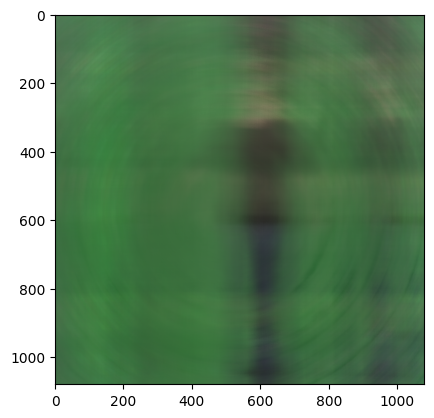

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
im = img.imread('/content/avatar_new_pose.png')
plt.imshow(im)

In [ ]:
render_new_avatar_pose(
        model,
        dataset,
        new_body_pose,
        new_betas,
        new_R,
        new_T,
        dataset.H,
        dataset.W,
        device="cuda",
        output_path="avatar_new_pose2.png",
    )

Avatar in new pose saved to avatar_new_pose2.png


tensor([[[0.3325, 0.4728, 0.3449],
         [0.3268, 0.4737, 0.3419],
         [0.3315, 0.4766, 0.3442],
         ...,
         [0.3407, 0.4819, 0.3425],
         [0.3400, 0.4775, 0.3365],
         [0.3402, 0.4781, 0.3418]],

        [[0.3253, 0.4728, 0.3406],
         [0.3316, 0.4780, 0.3456],
         [0.3232, 0.4710, 0.3408],
         ...,
         [0.3444, 0.4824, 0.3461],
         [0.3413, 0.4829, 0.3451],
         [0.3331, 0.4672, 0.3337]],

        [[0.3272, 0.4773, 0.3430],
         [0.3239, 0.4754, 0.3379],
         [0.3312, 0.4776, 0.3374],
         ...,
         [0.3399, 0.4858, 0.3458],
         [0.3408, 0.4833, 0.3441],
         [0.3350, 0.4781, 0.3444]],

        ...,

        [[0.2566, 0.4306, 0.2795],
         [0.2583, 0.4297, 0.2786],
         [0.2563, 0.4310, 0.2779],
         ...,
         [0.2548, 0.4534, 0.3008],
         [0.2542, 0.4485, 0.2945],
         [0.2549, 0.4423, 0.2999]],

        [[0.2573, 0.4316, 0.2796],
         [0.2581, 0.4300, 0.2801],
         [0.

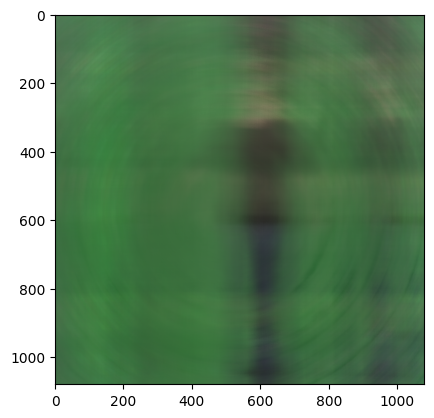

In [ ]:
im = img.imread('/content/avatar_new_pose2.png')
plt.imshow(im)

In [ ]:
print("body_poses shape:", dataset.body_poses.shape)

body_poses shape: torch.Size([757, 63])


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) выбираем кадр, позу которого хотим использовать
known_idx = 100   # можешь поставить любой индекс 0..756

print("Using pose from frame:", known_idx)

# 2) берём body_pose и betas прямо из датасета
known_body_pose = dataset.body_poses[known_idx].to(device)  # [63]
known_betas     = dataset.betas[known_idx].to(device)       # [10]

# 3) выбираем камеру, в которой хотим увидеть эту позу

# вариант А: камера кадра 0 (новый ракурс, но реальная поза)
new_R = dataset.R_all[0].to(device)     # [3,3]
new_T = dataset.T_all[0].to(device)     # [3]

# 4) рендерим
_ = render_new_avatar_pose(
    model,
    dataset,
    new_body_pose=known_body_pose,
    new_betas=known_betas,
    new_R=new_R,
    new_T=new_T,
    H=dataset.H,
    W=dataset.W,
    device="cuda",
    batch_size=4096,
    output_path=f"avatar_pose_{known_idx}_cam0.png",
)


Using pose from frame: 100
Avatar in new pose saved to avatar_pose_100_cam0.png


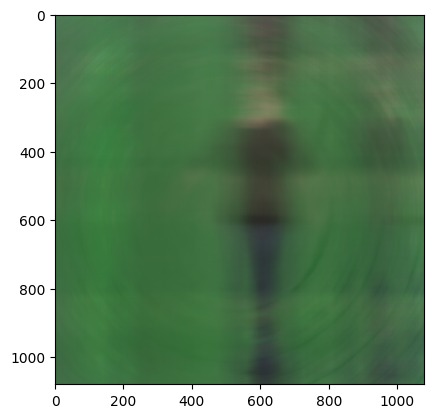

In [ ]:
im = img.imread('/content/avatar_pose_100_cam0.png')
plt.imshow(im)